# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Preparing data

In [2]:
train_path = './myArchive/train'
test_path = './myArchive/test'
valid_path = './myArchive/valid'

# Define image size and batch size
img_size = 256  # Adjust these values if your images have a different size
batch_size = 16

# Define ImageDataGenerators for loading and augmenting the data
train_datagen = ImageDataGenerator(rescale=1./255,              # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest' )
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Get the class names
class_names = list(train_generator.class_indices.keys())

# Display class names
print("Class names:", class_names)

Found 1946 images belonging to 10 classes.
Found 238 images belonging to 10 classes.
Found 255 images belonging to 10 classes.
Class names: ['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']


# Training

In [3]:
# Build the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax'),
])

# Compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=valid_generator,
                    callbacks=[cp_callback])

c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.1284 - loss: 2.4972
Epoch 1: saving model to training_1/cp.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 39s 308ms/step - accuracy: 0.1286 - loss: 2.4950 - val_accuracy: 0.2395 - val_loss: 2.0042
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.2036 - loss: 1.9851
Epoch 2: saving model to training_1/cp.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.2038 - loss: 1.9847 - val_accuracy: 0.3319 - val_loss: 1.7415
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2917 - loss: 1.7805
Epoch 3: saving model to training_1/cp.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.2917 - loss: 1.7802 - val_accuracy: 0.3950 - val_loss: 1.6609
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3364 - loss: 1.6654
Epoch 4: saving model to training_1/cp.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.3364 - loss: 1.6651 - val_accuracy: 0.420

# Testing the model

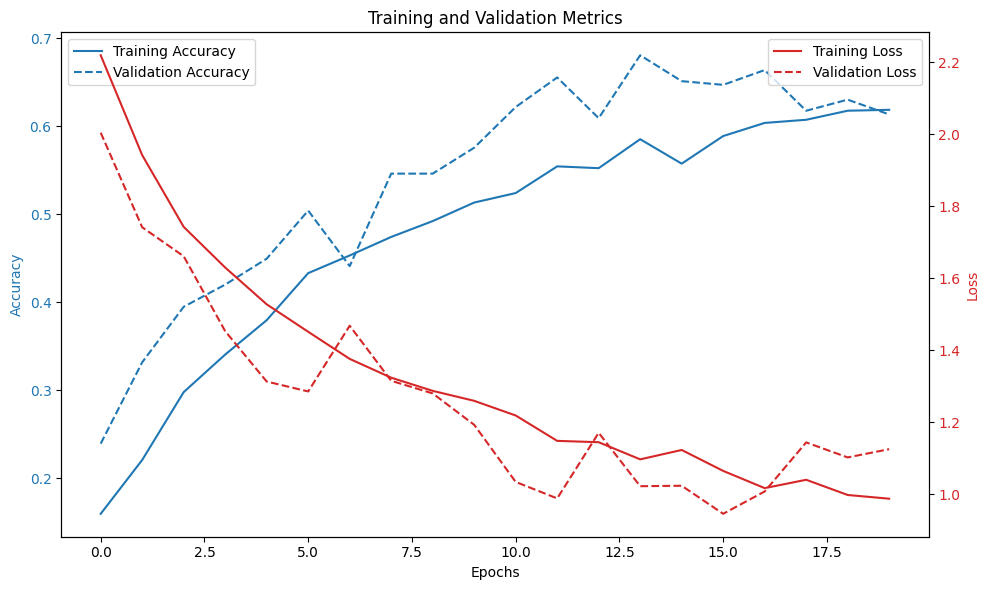

In [9]:
metrics_to_plot = ['accuracy', 'loss']


fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(history.history['accuracy'], label='Training Accuracy', color=color)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color=color, linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(history.history['loss'], label='Training Loss', color=color)
ax2.plot(history.history['val_loss'], label='Validation Loss', color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Training and Validation Metrics')

plt.tight_layout()
plt.show()

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8750 - loss: 0.6963

c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7092 - loss: 1.0932
Test accuracy: 0.6352941393852234
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
F1 Score:  0.10740190145619669
Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.10      0.12      0.11        26
        CARACAL       0.00      0.00      0.00        26
        CHEETAH       0.09      0.04      0.06        25
CLOUDED LEOPARD       0.05      0.08      0.06        25
         JAGUAR       0.12      0.19      0.15        26
          LIONS       0.21      0.20      0.20        25
         OCELOT       0.16      0.12      0.14        25
           PUMA       0.07      0.08      0.07        26
   SNOW LEOPARD       0.18      0.12      0.14        25
          TIGER       0.14      0.15      0.15        26

       accuracy                           0.11       255
      macro avg       0.11      0.11      0.11       255
   weighted avg       0.11      0.11      0.11       2

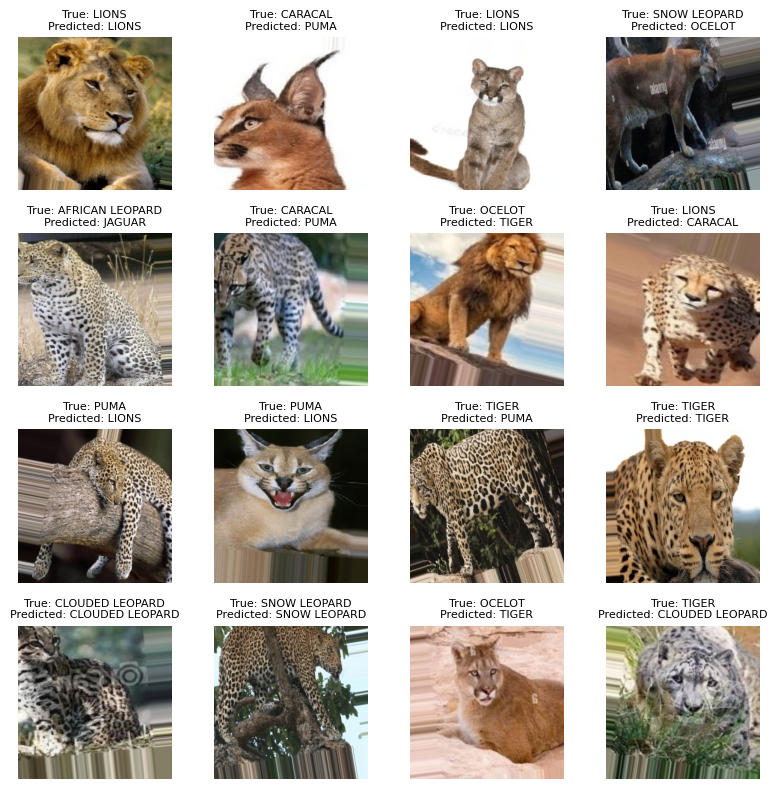

In [11]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Generate predictions
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels = np.argmax(predictions, axis=1)

# Gather true labels
true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))
true_labels = np.array(true_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels[:len(true_labels)], average='weighted')
print('F1 Score: ', f1)

# Classification report
report = classification_report(true_labels, predicted_labels[:len(true_labels)], target_names=class_names)
print('Classification Report:\n', report)

# Make predictions on the test dataset
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = list(test_generator.class_indices.keys())
for i in range(10):
    x_batch, y_batch = train_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))

    # print('true_labels', true_labels)
    # print('predicted_labels', predicted_labels)


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

print('true_class_labels', true_class_labels)
print('predicted_class_labels', predicted_class_labels)

# Plot true labels and predicted labels
plt.figure(figsize=(8, 8))
num_samples_to_display = min(16, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()



# Effnet

## Compile

In [12]:
# Load EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='elu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_effnet.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_effnet = model_effnet.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.0979 - loss: 2.3314 - val_accuracy: 0.1008 - val_loss: 2.3267
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.0797 - loss: 2.3377 - val_accuracy: 0.1429 - val_loss: 2.3321
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.0928 - loss: 2.3288 - val_accuracy: 0.1008 - val_loss: 2.3160
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.0875 - loss: 2.3325 - val_accuracy: 0.1008 - val_loss: 2.3201
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.0897 - loss: 2.3198 - val_accuracy: 0.1008 - val_loss: 2.3259
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.0868 - loss: 2.3261 - val_accuracy: 0.1008 - val_loss: 2.3086
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.1018 - loss: 2.3214 - val_accuracy: 0.0966 - val_loss: 2.3153
Epoch 8/10
122/122 ━━━━━━━━━━━━━

## Comparison

In [13]:
# Evaluate the model on the test dataset
test_loss_effnet, test_acc_effnet = model_effnet.evaluate(test_generator)
print('EfficientNetB0 Test accuracy:', test_acc_effnet)
from sklearn.metrics import f1_score, classification_report

# Generate predictions for the test set
predictions_effnet = model_effnet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels_effnet = np.argmax(predictions_effnet, axis=1)

# predictions_original = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
# predicted_labels_original = np.argmax(predictions_original, axis=1)

# Gather true labels
true_labels = test_generator.classes

# Calculate F1 scores
f1_effnet = f1_score(true_labels, predicted_labels_effnet[:len(true_labels)], average='weighted')
print('EfficientNetB0 F1 Score: ', f1_effnet)

# f1_original = f1_score(true_labels, predicted_labels_original[:len(true_labels)], average='weighted')
# print('Original Model F1 Score: ', f1_original)

# Classification reports
report_effnet = classification_report(true_labels, predicted_labels_effnet[:len(true_labels)], target_names=class_names)
print('EfficientNetB0 Classification Report:\n', report_effnet)

# report_original = classification_report(true_labels, predicted_labels_original[:len(true_labels)], target_names=class_names)
# print('Original Model Classification Report:\n', report_original)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1084 - loss: 2.3142
EfficientNetB0 Test accuracy: 0.09803921729326248
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step
EfficientNetB0 F1 Score:  0.01750700280112045
EfficientNetB0 Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.00      0.00      0.00        26
        CARACAL       0.00      0.00      0.00        26
        CHEETAH       0.00      0.00      0.00        25
CLOUDED LEOPARD       0.00      0.00      0.00        25
         JAGUAR       0.00      0.00      0.00        26
          LIONS       0.10      1.00      0.18        25
         OCELOT       0.00      0.00      0.00        25
           PUMA       0.00      0.00      0.00        26
   SNOW LEOPARD       0.00      0.00      0.00        25
          TIGER       0.00      0.00      0.00        26

       accuracy                           0.10       255
      macro avg       0.01      0.10      0.02       255
   weig

c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif